In [1]:
%matplotlib inline
import numpy as np
from TreeSearch import TreeSearch

![](images/cover.jpg)

# Tree Search and Visualization

### Xian Lai
xlai4@fordham.edu

=======================================================

Searching could be one of the most flexible way to deal with problem that can't be solved directly and exactly. If we know the final goal and want to obtain the path from initial state to goal state, then we need to save the states and orders we explored in a tree structure.

This small project includes implementation of a general tree search algorithm module that can be used for different searching strategies like depth-first search, iterative deepening search, A* search and so on, as well as a visualization module that can plot out the result search tree nicely.

And we will illustrate how to use this general tree search class to solve specific problem and output the search result to screen or to file in this Jupyter notebook.

### Libraries:
- TreeSearch.py
  This Python file implements the general tree search class that performs basic operations like expand node, evaluate state, append new nodes to tree as well as more complex strategies like depth first search, breath first search and so on.
  
  Input: 
  - initState: the initial state as the root
  - show_process: a boolean value. If true, the algorithm will print the intermediate search process on the screen.
  
  Result:
  - self.tree: the whole search tree as a nested list of dictionaries
  - self.paths: all the paths found as a nested list of dictionaries
  
- TreeVisual.py
  This Python file implements the setting and analysis required to plot the tree in a polar fig. 
  
### Example problem:
The example problem that used to illustrate the functions of above libraries is the Romania road trip problem described in Stuart Russell and Peter Norvig's book [Artificial Intelligence: a Modern Approach, 2010].

In the problem we are given a simplified city map of Romania with distances between each pair of cities reachable from each other(fig 3.2) and the straight line distances from each city to Bucharest(fig 3.22). Suppose an agent is in Arad and has to find a shortest way to reach Bucharest. What is the best path for it? 

<img src="images/RomaniaRoadMap.png" alt="Romania road map" style="width: 600px;"/>
<img src="images/SLD.png" alt="Straight line distance to Burcherest" style="width: 600px;"/>

---
references:
- title: Artificial Intelligence: a Modern Approach.
- author:
  - Russell, Stuart J.
  - Peter Norvig
- publisher: Prentice-Hall
- issued: 2010
---


## Collecting data in the problem 
First of all, we need to collect the information from the problem and the maps and write them as Python objects.

    - Environment: Romania
    - States: All the cities in the map
    - Step costs: Distances between cities
    - Actions: The agent can choose to go to any one of the cities directly connected to current city in one step
    - Heuristics: The straight line distance between each city and Bucharest
    - initial state: Arad
    - goal state: Bucharest

In [2]:
cities = sorted(['Rimnicu Vilcea','Sibiu','Craiova','Fagaras',
                 'Pitesti', 'Bucharest','Oradea','Zerind','Arad',
                 'Timisoara','Lugoj','Mehadia','Drobeta','Giurgiu',
                 'Urziceni','Hirsova','Eforie','Vaslui','Iasi','Neamt'])

distances = [['Vaslui', 'Iasi', 92],
             ['Iasi', 'Neamt', 87],
             ['Sibiu', 'Fagaras', 99],
             ['Sibiu', 'Rimnicu Vilcea', 80],
             ['Craiova', 'Rimnicu Vilcea', 146],
             ['Pitesti', 'Rimnicu Vilcea', 97],
             ['Craiova', 'Pitesti', 138],
             ['Pitesti', 'Bucharest', 101],
             ['Bucharest', 'Fagaras', 211],
             ['Mehadia', 'Drobeta', 75],
             ['Drobeta', 'Craiova', 120],
             ['Giurgiu', 'Bucharest', 90],
             ['Urziceni', 'Bucharest', 85],
             ['Urziceni', 'Vaslui', 142],
             ['Urziceni', 'Hirsova', 98],
             ['Hirsova', 'Eforie', 86],
             ['Oradea', 'Zerind', 71],
             ['Sibiu', 'Oradea', 151],
             ['Zerind', 'Arad', 75],
             ['Arad', 'Sibiu', 140],
             ['Arad', 'Timisoara', 118],
             ['Timisoara', 'Lugoj', 111],
             ['Lugoj', 'Mehadia', 211]]  

SLDs = {'Arad':366, 'Bucharest':0, 'Craiova':160, 'Drobeta':242,
        'Eforie':161, 'Fagaras':176, 'Giurgiu':77, 'Hirsova':151,
        'Iasi':226, 'Lugoj':244, 'Mehadia':241, 'Neamt':234, 
        'Oradea':380, 'Pitesti':100, 'Rimnicu Vilcea':193,
        'Sibiu':253, 'Timisoara':329, 'Urziceni':80, 'Vaslui':199,
        'Zerind':374}

## Specific problem class
Next, we will create a class--RoadtripProblem--defining the behavior for this specific problem with parent class pointed to TreeSearch.

In this RoadtripProblem class or any class of specific problem, we need to implement 3 methods that will be called during search:
    
- **_transition(self, state)**:  
  the transition model that takes in any state and return possible actions, children states and corresponding step costs.
        
- **_heuristicCost(self, state)**:  
  return the heuristic cost of any given state
        
- **_isGoal(self, state)**:  
  test whether given state is goal state.

In [3]:
class RoadtripProblem(TreeSearch):

    def __init__(self, states=None, initState=None, goalState=None, stepCosts=None, 
                 heuristics=None, show_progress=False):
        """ initiate the TreeSearch class and current class with input: states,  
        step costs, initial state, goal state and heuristics.
        """
        TreeSearch.__init__(self, initState=initState, show_progress=show_progress)
        self.states = states
        self.size = len(states)
        self.goalState = goalState
        self.heuristics = heuristics
        self._coding()
        self._update_stepCosts(stepCosts)

    def _coding(self):
        """ encode the state with integers because we are using matrix to record the
        step costs between each pair of cities. self.encoding will translate state to
        code and self.decoding will translate code to state.
        """
        self.encoding = {}; self.decoding = {}
        for i in range(self.size):
            self.encoding.update({self.states[i]:i})
            self.decoding.update({i:self.states[i]})
            
    def _update_stepCosts(self, stepCosts):
        """ use adjacency matrix to represent the step costs. Each element of matrix 
        represent the distance between row city and column city. The pair of cities 
        without direct connect will have infinite distance.
        """
        # we set up the matrix with all cities unconnected to each other.
        self.stepCosts = np.full((self.size, self.size), np.inf)
        
        # and then we start to update the matrix from the diagonal which row and column 
        # indicate the same city.
        np.fill_diagonal(self.stepCosts, 0)
        
        # and then we update the connected cities. The matrix is symmetric along diagonal.
        for dist in stepCosts:
            self.stepCosts[self.encoding[dist[0]], self.encoding[dist[1]]] = dist[2]
            self.stepCosts[self.encoding[dist[1]], self.encoding[dist[0]]] = dist[2]

    def print_encoding(self):
        """ print out the encodings
        """
        print('The encoding of states:')
        for i in range(self.size):
            print('%d : %s' % (i, self.states[i]))

    def _transition(self, state):
        """ the transition model that takes in a state, return the possible actions,
        children states and corresponding step costs.
        """
        childStates, actions, stepCosts= [], [], []
        
        s = self.encoding[state]
        # iterate through all cities, if a city is connected to current city and 
        # it is not the current city itself, it is one of the successors.
        for i in range(self.size):
            if (self.stepCosts[s,i] != np.inf) & (self.stepCosts[s,i] != 0):
                childStates.append(self.decoding[i])
                actions.append("go " + self.decoding[i])
                stepCosts.append(self.stepCosts[s,i])

        return actions, childStates, stepCosts
    
    def _heuristicCost(self, state):
        """ return the heuristic cost of given state
        """
        if self.heuristics == None: return 0
        else: return self.heuristics[state]
        
    def _isGoal(self, state):
        """ test whether given state is goal state.
        """
        if state == self.goalState: return True

### Documentation
Now we have the specific problem class that can be used for search.

**class** SpecificProblem(states=None, initState=None, goalState=None, stepCosts=None, heuristics=None, show_progress=False)

**Parameters**:
- **states**: all the states in the problem environment
- **initState**: the initial state to begin search
- **goalState**: the goal state
- **stepCosts**: the step costs from a state to another state
- **heuristics**: the heuristics from a state to goal state
- **show_progress**: controls whether we want to print the searching progress on screen.

**Attributes**:
- **states**: all the states
- **size**: the number of all possible states
- **initState**: the initial state
- **goalState**: the goal state
- **heuristics**: the heuristics of each state

- **tree**: the search tree
- **paths**: the paths found
- **n_nodes**: the number of nodes in the search tree
- **n_gnrt**: the number of layers in the search tree

**Methods**:
- **breadthFirstSearch(maxNodes=np.inf, maxLayers=np.inf)** 
- **depthFirstSearch(maxNodes=np.inf, maxLayers=np.inf)**
- **uniformCostSearch(maxNodes=np.inf, maxLayers=np.inf)**
- **iterativeDeepeningSearch(maxDepth=5)**
- **bestFirstSearch(maxNodes=np.inf, maxLayers=np.inf)**
- **aStarSearch(maxNodes=np.inf, maxLayers=np.inf)**

- **print_paths()**
- **print_tree()**
- **plot_tree(diameter=50, background='dark', ls='-', a=0.8, title='Search Tree')**
- **export()**

**\__init\__**(states=None, initState=None, goalState=None, stepCosts=None, heuristics=None, show_progress=False)
    
**breadthFirstSearch**(maxNodes=np.inf, maxLayers=np.inf)  
    The breadth first search that always push and expand the first node saved in the frontier list.
    *Parameters*:
    - maxNodes: The maximum nodes to be explored before stopping the searching.
    - maxLayers: The maximum layers to be explored before stopping the searching.
    If neither of these is set, then the search will stop when the first path is found.

**depthFirstSearch**(maxNodes=np.inf, maxLayers=np.inf)  
    The depth first search that always push and expand the last node saved in the frontier list.
    *Parameters*:
    - maxNodes: The maximum nodes to be explored before stopping the searching.
    - maxLayers: The maximum layers to be explored before stopping the searching.
    If neither of these is set, then the search will stop when the first path is found.
    
**uniformCostSearch**(maxNodes=np.inf, maxLayers=np.inf)  
    The uniform cost search that always push and expand the node with least path cost in the frontier list.
    *Parameters*:
    - maxNodes: The maximum nodes to be explored before stopping the searching.
    - maxLayers: The maximum layers to be explored before stopping the searching.
    If neither of these is set, then the search will stop when the first path is found.
    
**iterativeDeepeningSearch**(maxDepth=5)  
    The iterative deepening search that iteratively performs DFS with maximum layers increasing. The search will stop when it finds the first goal or finished the last iteration with maxLayer equals maxDepth.
    *Parameters*:
    - maxDepth: The maximum layers of last iteration of DFS.
    
**bestFirstSearch**(maxNodes=np.inf, maxLayers=np.inf)  
    The best first search that always push and expand the node with least heuristic in the frontier list.
    *Parameters*:
    - maxNodes: The maximum nodes to be explored before stopping the searching.
    - maxLayers: The maximum layers to be explored before stopping the searching.
    If neither of these is set, then the search will stop when the first path is found.

**aStarSearch**(maxNodes=np.inf, maxLayers=np.inf)  
    The A* search that uses the sum of path cost and heuristic to determine which node in the frontier to push and expand.
    *Parameters*:
    - maxNodes: The maximum nodes to be explored before stopping the searching.
    - maxLayers: The maximum layers to be explored before stopping the searching.
    If neither of these is set, then the search will stop when the first path is found.

**print_paths**()  
    Print out the the paths found.
    
**print_tree**()  
    Print out the whole search tree using pprint.
    
**plot_tree**(diameter=50, background='dark', ls='-', a=0.8, title='Search Tree')  
    Plot out the search tree in a polar figure.
    *Parameters*:
    - diameter: The nodes of tree has to spread out in the plot without overlapping, so the bigger diameter, more sparse the nodes are.
    - background: The background color of fig, could be either 'light' or 'dark'.
    - ls: line style.
    - a: alpha of nodes and edges.
    - title: The title of this plot.
    
**export**()   
    Write tree and paths as JSON files into current directory.
    

## Illustration of parameters and methods

In [4]:
params = {'states':cities, 'initState':'Arad', 'goalState':'Bucharest',
          'stepCosts':distances, 'heuristics':SLDs}

### breadthFirstSearch(maxLayers=3) & show_progress =True
If we set show_progress to True when initializing the RoadtripProblem instance, the search will print out which node it is expanding now and what are the currently total number of nodes, layers and paths.

In [5]:
problem = RoadtripProblem(show_progress=True, **params)
problem.breadthFirstSearch(maxLayers=3)

BFS search begins:
the search will stop when infinite nodes or             
every nodes in 3 generations are discovered

now expanding: generation:(0); clst:(0); sibl:(0); state:(Arad)
total number of nodes : 1, 
total number of layers : 0,            
number of paths found : 0

now expanding: generation:(1); clst:(0); sibl:(2); state:(Zerind)
total number of nodes : 4, 
total number of layers : 2,            
number of paths found : 0

now expanding: generation:(1); clst:(0); sibl:(1); state:(Timisoara)
total number of nodes : 6, 
total number of layers : 3,            
number of paths found : 0

now expanding: generation:(1); clst:(0); sibl:(0); state:(Sibiu)
total number of nodes : 8, 
total number of layers : 3,            
number of paths found : 0

now expanding: generation:(2); clst:(2); sibl:(1); state:(Oradea)
total number of nodes : 12, 
total number of layers : 3,            
number of paths found : 0

now expanding: generation:(2); clst:(2); sibl:(0); state:(Arad)
total num

### depthFirstSearch(maxNodes=100) & print_paths()
After searching, we can choose to print out the paths found. The real paths saved are nested list of nodes, and what will be print out are the informtion extracted from each node.    
[path_0, path_1, ...]    
 path_# = [   
 {'action':action_0, 'state':state_0, 'pathCost':pathCost_0},     
 {'action':action_1, 'state':state_1, 'pathCost':pathCost_1},    
 ...    
 ]

In [6]:
problem = RoadtripProblem(show_progress=False, **params)
problem.depthFirstSearch(maxNodes=100)
problem.print_paths()

DFS search begins:
the search will stop when 100 nodes or             
every nodes in infinite generations are discovered
search ends

2 paths found:
[[{'action': 'initialize', 'pathCost': 0, 'state': 'Arad'},
  {'action': 'go Sibiu', 'pathCost': 140.0, 'state': 'Sibiu'},
  {'action': 'go Fagaras', 'pathCost': 239.0, 'state': 'Fagaras'},
  {'action': 'go Bucharest', 'pathCost': 450.0, 'state': 'Bucharest'}],
 [{'action': 'initialize', 'pathCost': 0, 'state': 'Arad'},
  {'action': 'go Sibiu', 'pathCost': 140.0, 'state': 'Sibiu'},
  {'action': 'go Rimnicu Vilcea', 'pathCost': 220.0, 'state': 'Rimnicu Vilcea'},
  {'action': 'go Pitesti', 'pathCost': 317.0, 'state': 'Pitesti'},
  {'action': 'go Bucharest', 'pathCost': 418.0, 'state': 'Bucharest'}]]


### uniformCostSearch(maxNodes=100) & print_tree()
Besides path, we can also choose to print out the whole search tree. Usually this is very long but it is useful if you want to look at the detail of the result.

In [7]:
problem = RoadtripProblem(show_progress=False, **params)
problem.uniformCostSearch(maxNodes=100)
problem.print_tree()

UCS search begins:
the search will stop when 100 nodes or             
every nodes in infinite generations are discovered
search ends

Tree searched:
[[[{'children': 0,
    'clst': 0,
    'expanded': True,
    'gnrt': 0,
    'heuristic': 99999,
    'parent': [],
    'pathCost': 0,
    'prevAction': 'initialize',
    'sibl': 0,
    'state': 'Arad'}]],
 [[{'children': 0,
    'clst': 0,
    'expanded': True,
    'gnrt': 1,
    'heuristic': 253,
    'parent': [0, 0],
    'pathCost': 140.0,
    'prevAction': 'go Sibiu',
    'sibl': 0,
    'state': 'Sibiu'},
   {'children': 1,
    'clst': 0,
    'expanded': True,
    'gnrt': 1,
    'heuristic': 329,
    'parent': [0, 0],
    'pathCost': 118.0,
    'prevAction': 'go Timisoara',
    'sibl': 1,
    'state': 'Timisoara'},
   {'children': 2,
    'clst': 0,
    'expanded': True,
    'gnrt': 1,
    'heuristic': 374,
    'parent': [0, 0],
    'pathCost': 75.0,
    'prevAction': 'go Zerind',
    'sibl': 2,
    'state': 'Zerind'}]],
 [[{'children': 0,

    'prevAction': 'go Pitesti',
    'sibl': 1,
    'state': 'Pitesti'},
   {'children': None,
    'clst': 3,
    'expanded': False,
    'gnrt': 4,
    'heuristic': 193,
    'parent': [3, 0],
    'pathCost': 512.0,
    'prevAction': 'go Rimnicu Vilcea',
    'sibl': 2,
    'state': 'Rimnicu Vilcea'}],
  [{'children': None,
    'clst': 4,
    'expanded': False,
    'gnrt': 4,
    'heuristic': 0,
    'parent': [3, 1],
    'pathCost': 418.0,
    'prevAction': 'go Bucharest',
    'sibl': 0,
    'state': 'Bucharest'},
   {'children': None,
    'clst': 4,
    'expanded': False,
    'gnrt': 4,
    'heuristic': 160,
    'parent': [3, 1],
    'pathCost': 455.0,
    'prevAction': 'go Craiova',
    'sibl': 1,
    'state': 'Craiova'},
   {'children': None,
    'clst': 4,
    'expanded': False,
    'gnrt': 4,
    'heuristic': 193,
    'parent': [3, 1],
    'pathCost': 414.0,
    'prevAction': 'go Rimnicu Vilcea',
    'sibl': 2,
    'state': 'Rimnicu Vilcea'}],
  [{'children': None,
    'clst': 5,
   

### iterativeDeepeningSearch(maxDepth=5) & plot_tree(diameter=10)
The best way to avoid the long print-out is to visualize it. The plot_tree method is exactly for this purpose. It will plot the search tree in polar manner.

The result plotting is shown in the fig below, all nodes are colored based on path cost and the path and goal state are marked by green color. And you can see the tree search stopped when it found the goal state in layer 3.

DFS search begins:
the search will stop when infinite nodes or             
every nodes in 1 generations are discovered
search ends
DFS search begins:
the search will stop when infinite nodes or             
every nodes in 2 generations are discovered
search ends
DFS search begins:
the search will stop when infinite nodes or             
every nodes in 3 generations are discovered
search ends


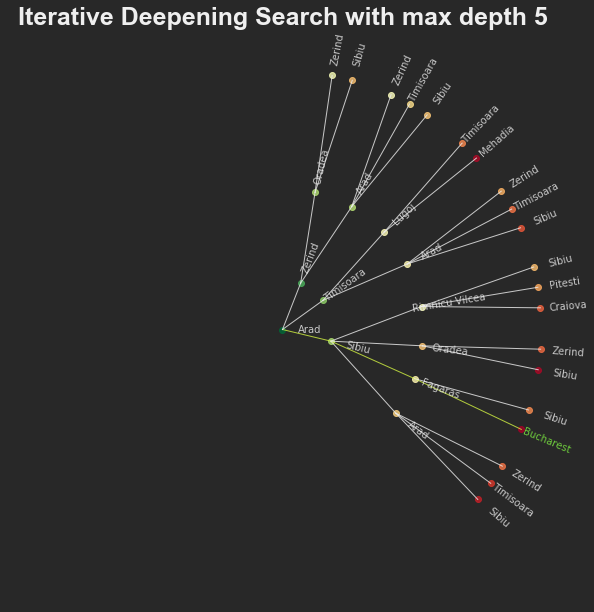

In [8]:
problem = RoadtripProblem(show_progress=False, **params)
problem.iterativeDeepeningSearch(maxDepth=5)
problem.plot_tree(diameter=10, background='dark', ls='-', a=0.8,
                  title='Iterative Deepening Search with max depth 5')

### bestFirstSearch(maxLayers=6) & plot_tree(diameter=30)

bestFS search begins:
the search will stop when infinite nodes or             
every nodes in 6 generations are discovered
search ends


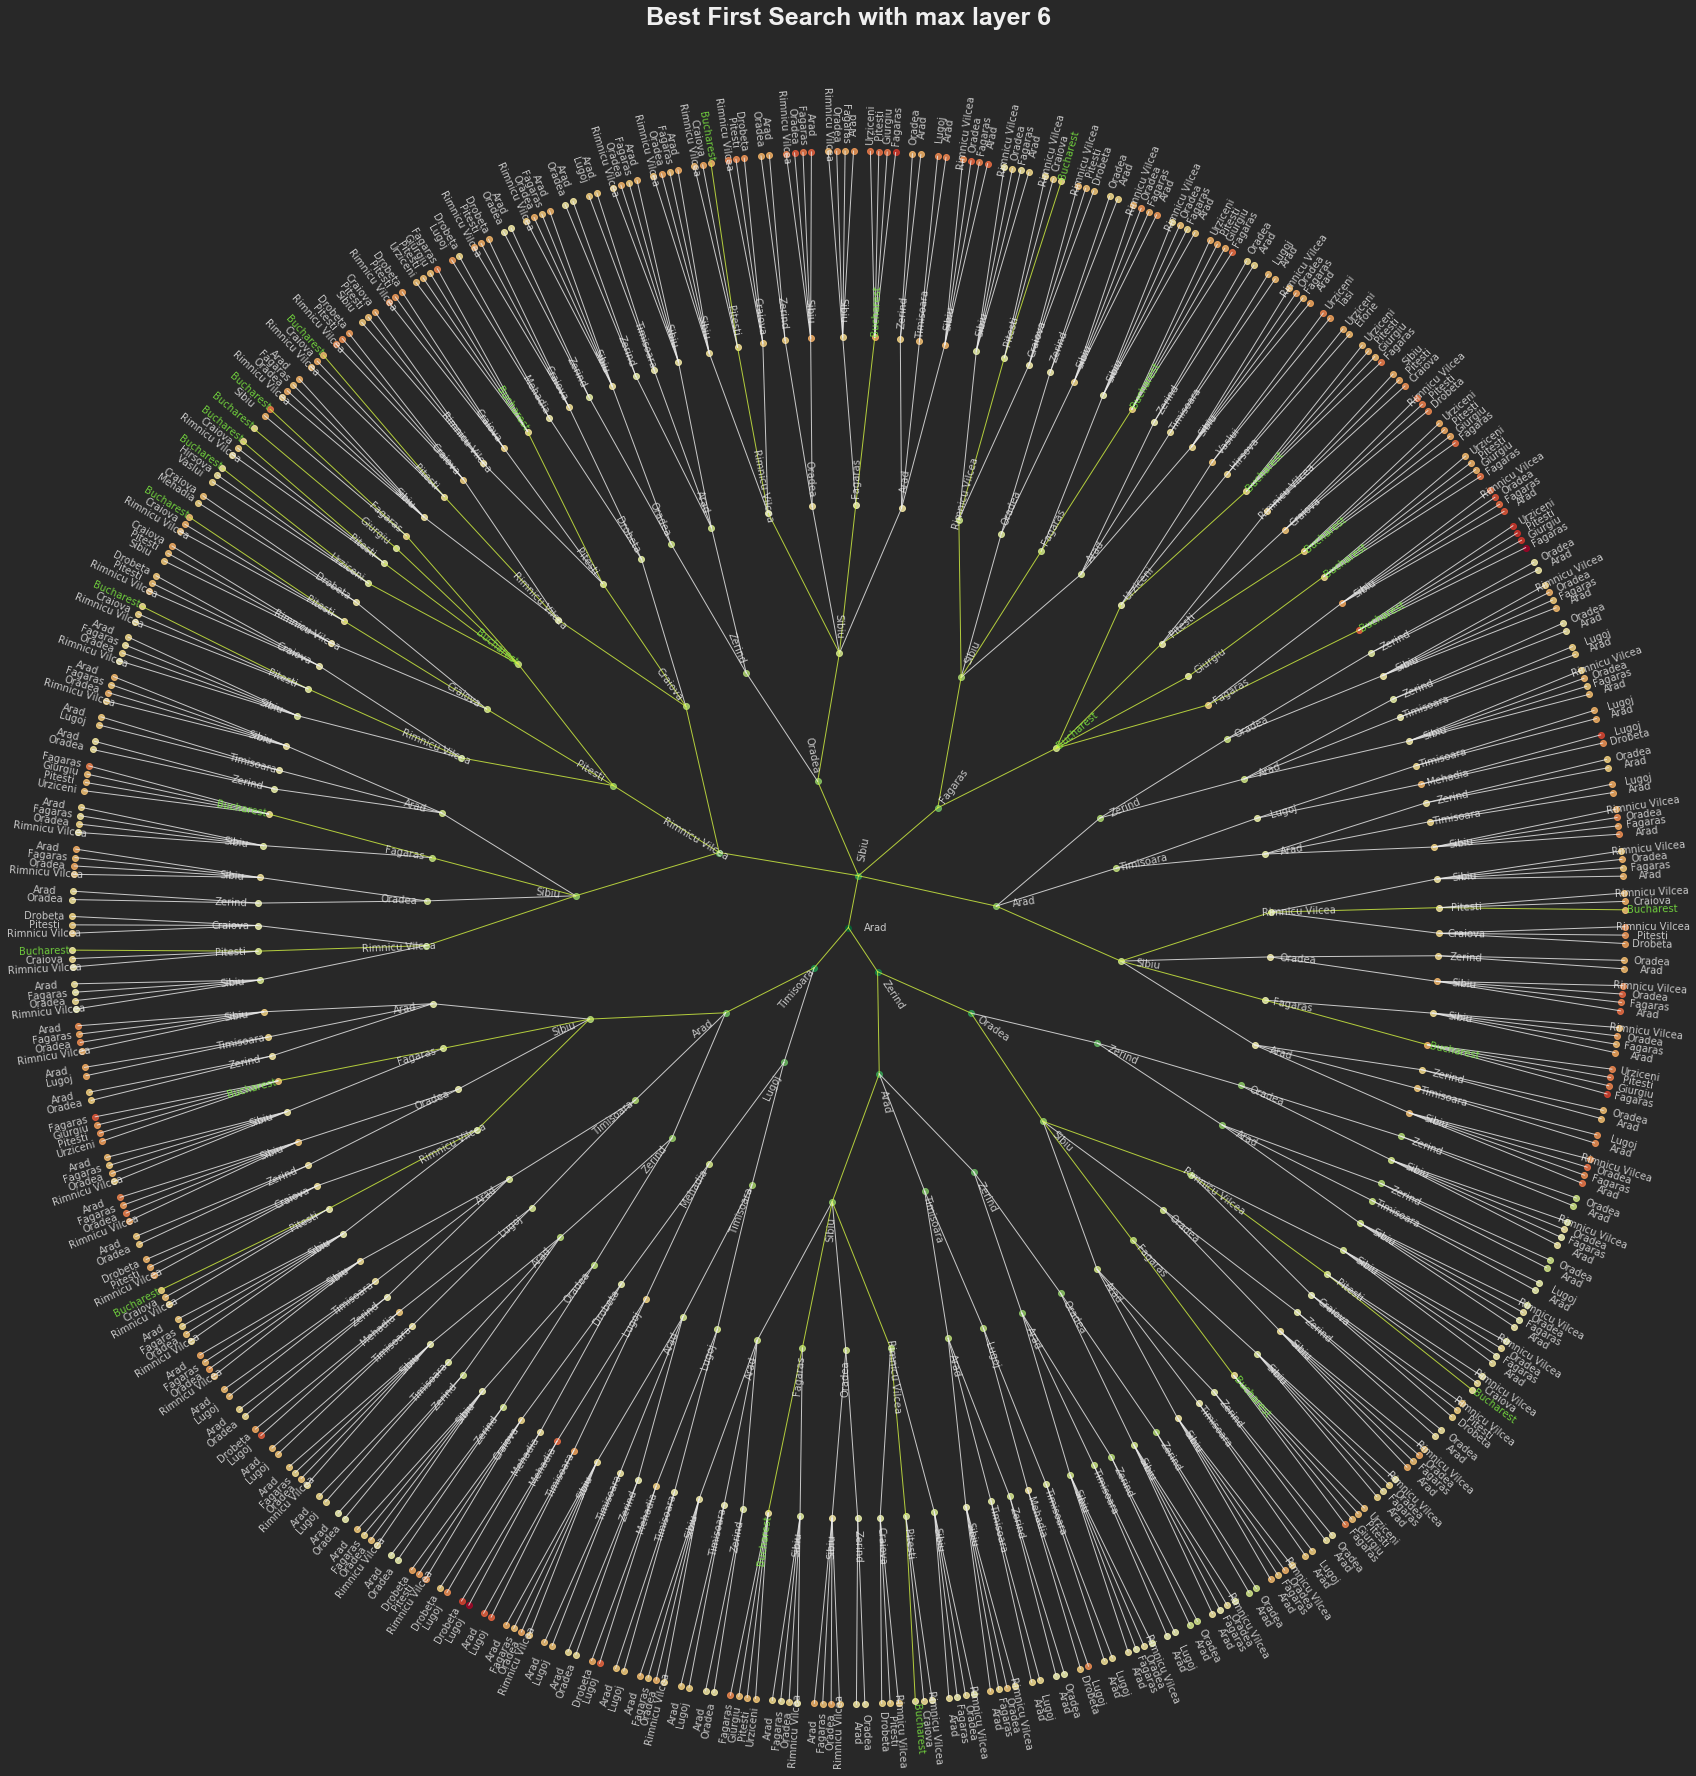

In [9]:
problem = RoadtripProblem(show_progress=False, **params)
problem.bestFirstSearch(maxLayers=6)
problem.plot_tree(diameter=30, title="Best First Search with max layer 6")

### aStarSearch(maxNodes=500) & plot_tree(diameter=30) & export()
Finally, we can choose to write the searching result as JSON file in current directory by method problem.export().

aStar search begins:
the search will stop when 500 nodes or             
every nodes in infinite generations are discovered
search ends


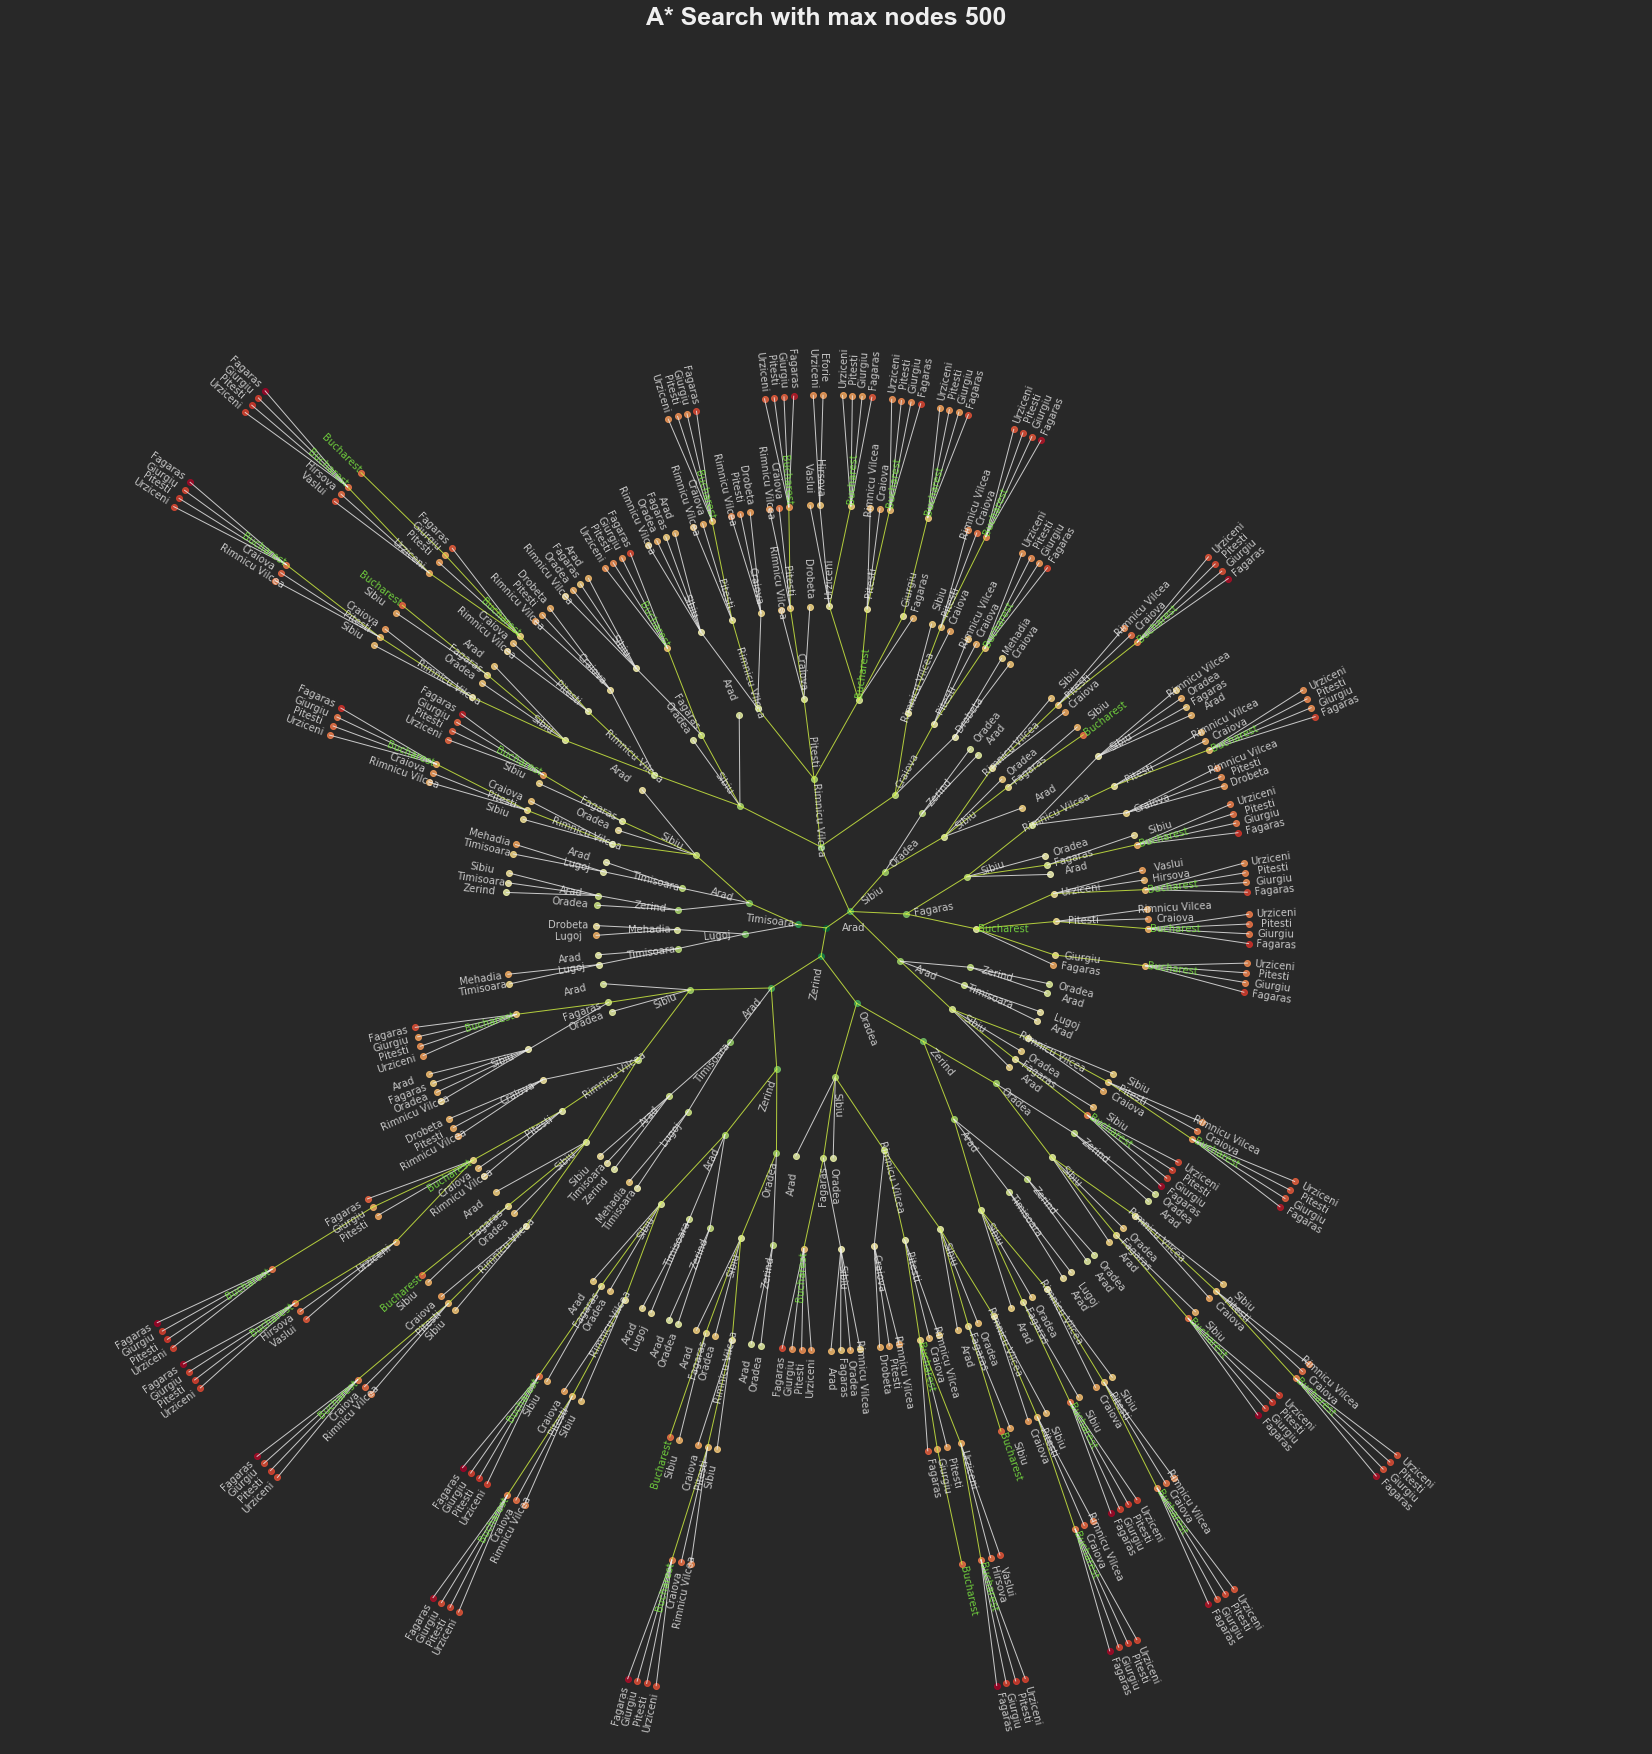

In [10]:
problem = RoadtripProblem(show_progress=False, **params)
problem.aStarSearch(maxNodes=500)
problem.plot_tree(diameter=30, title="A* Search with max nodes 500")
problem.export()